In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import src.data.names_data as NamesData
import src.data.movies_char_data as MovieChar
from src.utils.data_utils import *
from src.utils.movies_utils import *
from src.utils.names_utils import merge_names_data
from src.models.trend_evaluation import trend_eval_ranking
from src.models.imdb_manipulation import *
from src.models.trend_evaluation import plot_trend
from sklearn.linear_model import LinearRegression

In [5]:
from src.models.naming_prediction import predict_naming_ARIMA

In [6]:
ukNames = NamesData.UKNamesData("UK", "ukbabynames.csv")
ukNames.clean_raw_data()

frenchNames = NamesData.FranceNamesData("France", "france.csv", "https://www.insee.fr/fr/statistiques/8205621?sommaire=8205628#dictionnaire", ";")
frenchNames.clean_raw_data()

USNames = NamesData.USNamesData("US", "babyNamesUSYOB-full.csv")
USNames.clean_raw_data()

global_names = merge_names_data([ukNames, frenchNames, USNames])

UK : loaded 565817 rows !
UK : Data is clean and conforms to the expected structure !
France : loaded 3884324 rows !
France : Data is clean and conforms to the expected structure !
US : loaded 1858689 rows !
US : Data is clean and conforms to the expected structure !
UK : Data is clean and conforms to the expected structure !
France : Data is clean and conforms to the expected structure !
US : Data is clean and conforms to the expected structure !
UK & France & US : Data is clean and conforms to the expected structure !


In [7]:
# Print size of 3 datasets
print("UK names: ", ukNames().shape)
print("French names: ", frenchNames().shape)
print("US names: ", USNames().shape)

UK names:  (446642, 4)
French names:  (265468, 4)
US names:  (1858689, 4)


In [9]:
def augment_prediction_with_stop_year(prediction: pd.DataFrame, data: NamesData, name: str, stop_year: int) -> pd.DataFrame:
    """
    Augments the prediction DataFrame with the value of stop_year in the 'Year' column and the corresponding count in the 'True Count' and 'Predicted Count' columns.

    :param prediction: DataFrame containing the predictions
    :param data: the name dataset
    :param name: the name from which we predict the evolution
    :param stop_year: the year of the event
    :return: Augmented DataFrame
    """
    # Get the true count for the stop_year
    input_data = data().copy()
    true_count = input_data[(input_data['Name'] == name) & (input_data['Year'] == stop_year)]['Count'].values[0]

    # Create a new row with the stop_year and true count
    new_row = pd.DataFrame({'Year': [stop_year], 'True Count': [true_count], 'Predicted Count': [true_count]})

    # Append the new row to the prediction DataFrame
    augmented_prediction = pd.concat([new_row, prediction], ignore_index=True)

    return augmented_prediction

In [27]:
def linear_regression_on_predictions(prediction_df: pd.DataFrame, stop_year: int, nb_years: int, plot: bool = False, want_slopes_ratio: bool = False) -> float:
    """
    Performs linear regression on the 'True Count' and 'Predicted Count' values corresponding to years between [stop_year; stop_year + nb_years].
    Prints the slopes of both regressions and the result of the division between both slopes.
    Plots both linear regressions on the same plot.

    :param prediction_df: DataFrame containing the columns 'Year', 'Predicted Count', and 'True Count'
    :param stop_year: The starting year for the regression
    :param nb_years: The number of years to include in the regression
    """
    # Filter the data for the specified years
    df_filtered = prediction_df[(prediction_df['Year'] >= stop_year) & (prediction_df['Year'] <= stop_year + nb_years)]

    # Check if there are enough data points
    if df_filtered.shape[0] < 2:
        raise ValueError("Not enough data points for linear regression")

    # Prepare the data for linear regression
    X = df_filtered[['Year']].values.reshape(-1, 1)
    y_true = df_filtered['True Count'].values
    y_pred = df_filtered['Predicted Count'].values

    # Create and fit the linear regression model for True Count
    model_true = LinearRegression()
    model_true.fit(X, y_true)
    slope_true = model_true.coef_[0]

    # Create and fit the linear regression model for Predicted Count
    model_pred = LinearRegression()
    model_pred.fit(X, y_pred)
    slope_pred = model_pred.coef_[0]
    
    # If any of the slopes is 0, it takes the value 0.1
    if slope_true == 0:
        slope_true = 0.1
    if slope_pred == 0:
        slope_pred = 0.1
    
    # Print the slopes and the result of the division
    print(f"Slope of True Count: {slope_true}")
    print(f"Slope of Predicted Count: {slope_pred}")
    print(f"Division of slopes (True Count / Predicted Count): {slope_true / slope_pred}")

    if plot == True:
        # Plot the data and the linear regressions
        plt.figure(figsize=(16, 8))
        sns.lineplot(x='Year', y='True Count', data=df_filtered, label='True Count')
        sns.lineplot(x='Year', y='Predicted Count', data=df_filtered, label='Predicted Count')
    
        # Plot the linear regression lines
        plt.plot(df_filtered['Year'], model_true.predict(X), label='True Count Regression', linestyle='--')
        plt.plot(df_filtered['Year'], model_pred.predict(X), label='Predicted Count Regression', linestyle='--')
    
        plt.title('Linear Regression on True Count and Predicted Count')
        plt.xlabel('Year')
        plt.ylabel('Count')
        plt.legend()
        plt.show()
        
    if want_slopes_ratio:
        return slope_true / slope_pred


In [16]:
# LEIA case
prediction_LEIA = predict_naming_ARIMA(global_names, "LEIA", 1976, 5, False)

UK & France & US : Data is clean and conforms to the expected structure !


In [17]:
prediction_LEIA = augment_prediction_with_stop_year(prediction_LEIA, global_names, "LEIA", 1976)

Slope of True Count: 19.485714285714288
Slope of Predicted Count: -0.5281233922724841
Division of slopes (True Count / Predicted Count): -36.89613936975675


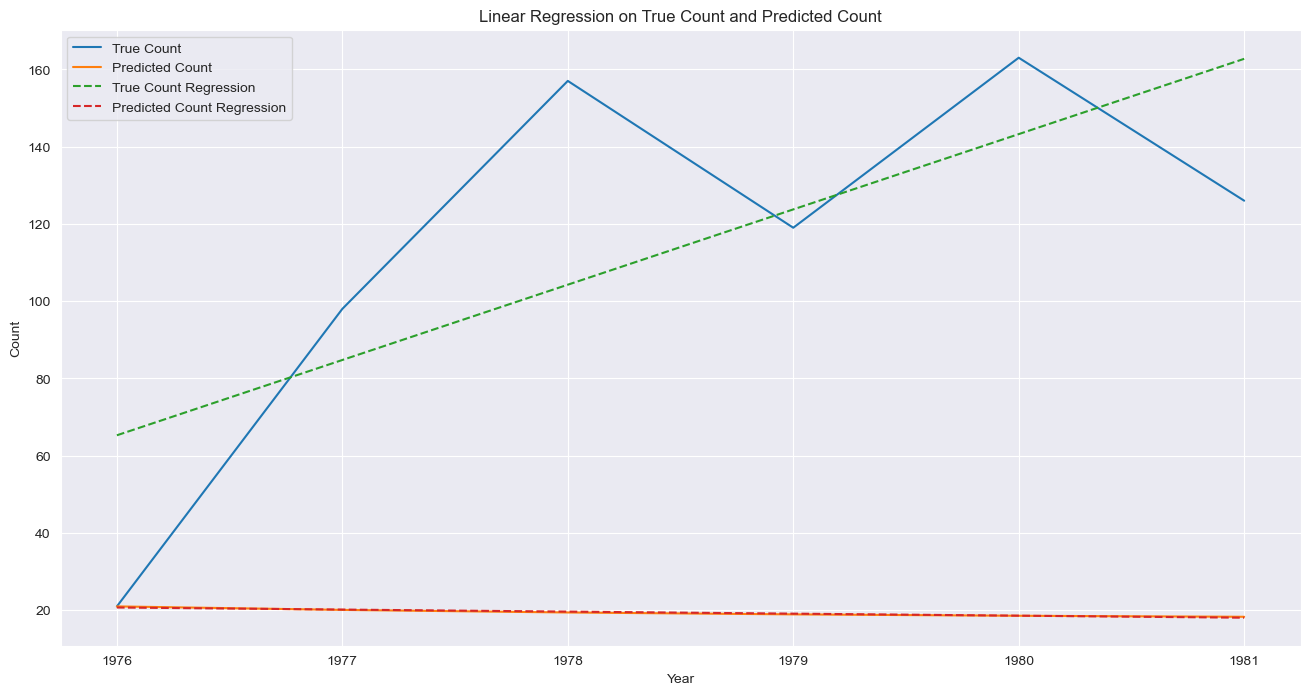

In [18]:
linear_regression_on_predictions(prediction_LEIA, 1976, 5, True)

In [ ]:
prediction_LUKE = predict_naming_ARIMA(global_names, "LUKE", 1976, 10, False)

In [ ]:
prediction_LUKE

In [ ]:
# Augment the prediction DataFrame with the stop year
prediction_LUKE = augment_prediction_with_stop_year(prediction_LUKE, global_names, "LUKE", 1976)

In [ ]:
prediction_LUKE

In [ ]:
linear_regression_on_predictions(prediction_LUKE, 1976, 10)

UK & France & US : Data is clean and conforms to the expected structure !


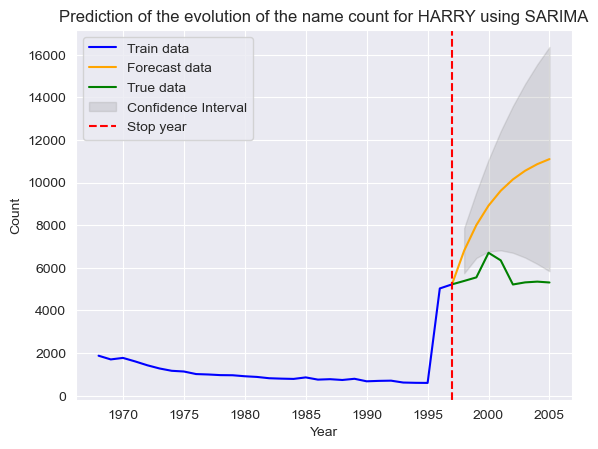

UK & France & US : Data is clean and conforms to the expected structure !


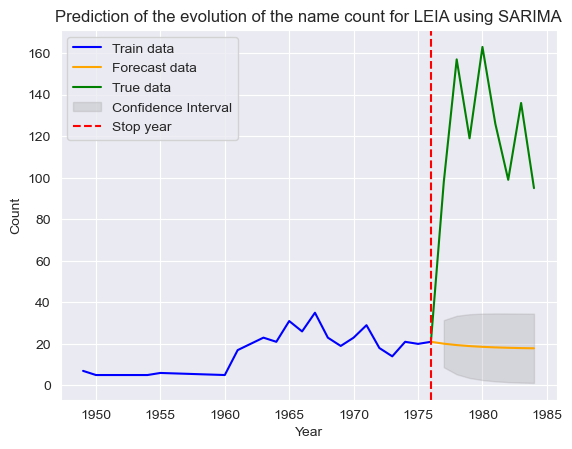

UK & France & US : Data is clean and conforms to the expected structure !


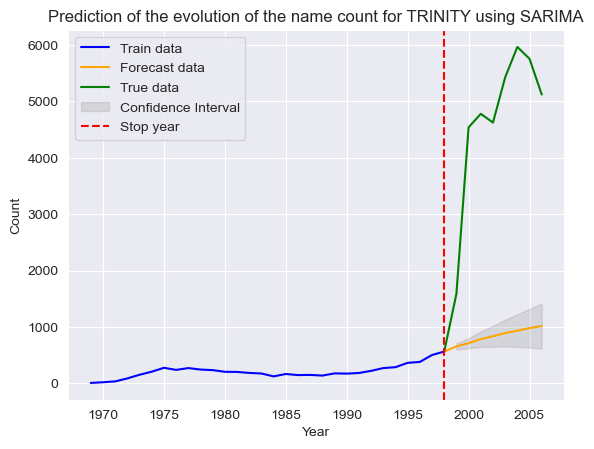

UK & France & US : Data is clean and conforms to the expected structure !


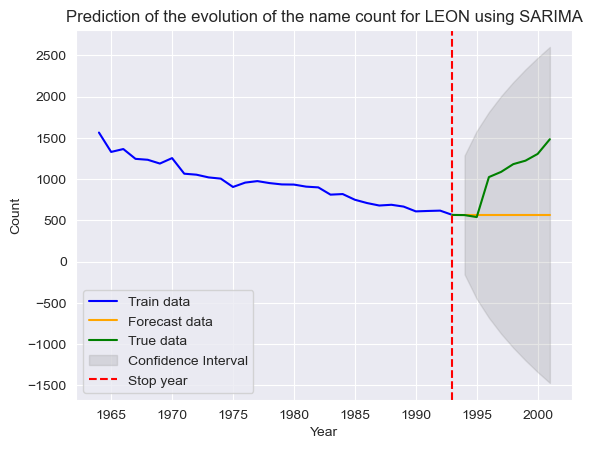

UK & France & US : Data is clean and conforms to the expected structure !


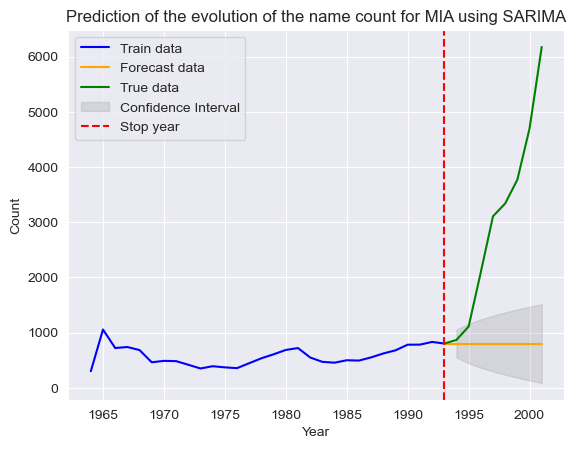

In [20]:
# Create a bunch of different prediction dataframes by taking names famously associated with different movies and their release years
prediction_HARRY    = predict_naming_ARIMA(global_names, "HARRY", 1997, 8, True)
prediction_LEIA     = predict_naming_ARIMA(global_names, "LEIA", 1976, 8, True)
prediction_TRINITY  = predict_naming_ARIMA(global_names, "TRINITY", 1998, 8, True)
prediction_LEON     = predict_naming_ARIMA(global_names, "LEON", 1993, 8, True)
prediction_MIA      = predict_naming_ARIMA(global_names, "MIA", 1993, 8, True)

In [21]:
# Augment the prediction DataFrames with the stop years
prediction_HARRY    = augment_prediction_with_stop_year(prediction_HARRY, global_names, "HARRY", 1997)
prediction_LEIA     = augment_prediction_with_stop_year(prediction_LEIA, global_names, "LEIA", 1976)
prediction_TRINITY  = augment_prediction_with_stop_year(prediction_TRINITY, global_names, "TRINITY", 1998)
prediction_LEON     = augment_prediction_with_stop_year(prediction_LEON, global_names, "LEON", 1993)
prediction_MIA      = augment_prediction_with_stop_year(prediction_MIA, global_names, "MIA", 1993)

In [22]:
# Perform linear regression on the predictions and watch the slopes ratio
linear_regression_on_predictions(prediction_HARRY, 1997, 10)
linear_regression_on_predictions(prediction_LEIA, 1976, 10)
linear_regression_on_predictions(prediction_TRINITY, 1998, 10)
linear_regression_on_predictions(prediction_LEON, 1993, 10)
linear_regression_on_predictions(prediction_MIA, 1993, 10)

Slope of True Count: -28.416666666666675
Slope of Predicted Count: 700.250471145049
Division of slopes (True Count / Predicted Count): -0.04058071766835053
Slope of True Count: 5.016666666666667
Slope of Predicted Count: -0.36845136899797815
Division of slopes (True Count / Predicted Count): -13.615546280394456
Slope of True Count: 575.1833333333335
Slope of Predicted Count: 60.57386298167673
Division of slopes (True Count / Predicted Count): 9.495569623937033
Slope of True Count: 123.71666666666668
Slope of Predicted Count: 0.1
Division of slopes (True Count / Predicted Count): 1237.1666666666667
Slope of True Count: 659.9166666666667
Slope of Predicted Count: 0.4000000000000001
Division of slopes (True Count / Predicted Count): 1649.7916666666665


UK & France & US : Data is clean and conforms to the expected structure !
Slope of True Count: 8.44999999999999
Slope of Predicted Count: 39.65821596244127
Division of slopes (True Count / Predicted Count): 0.21307060327682548


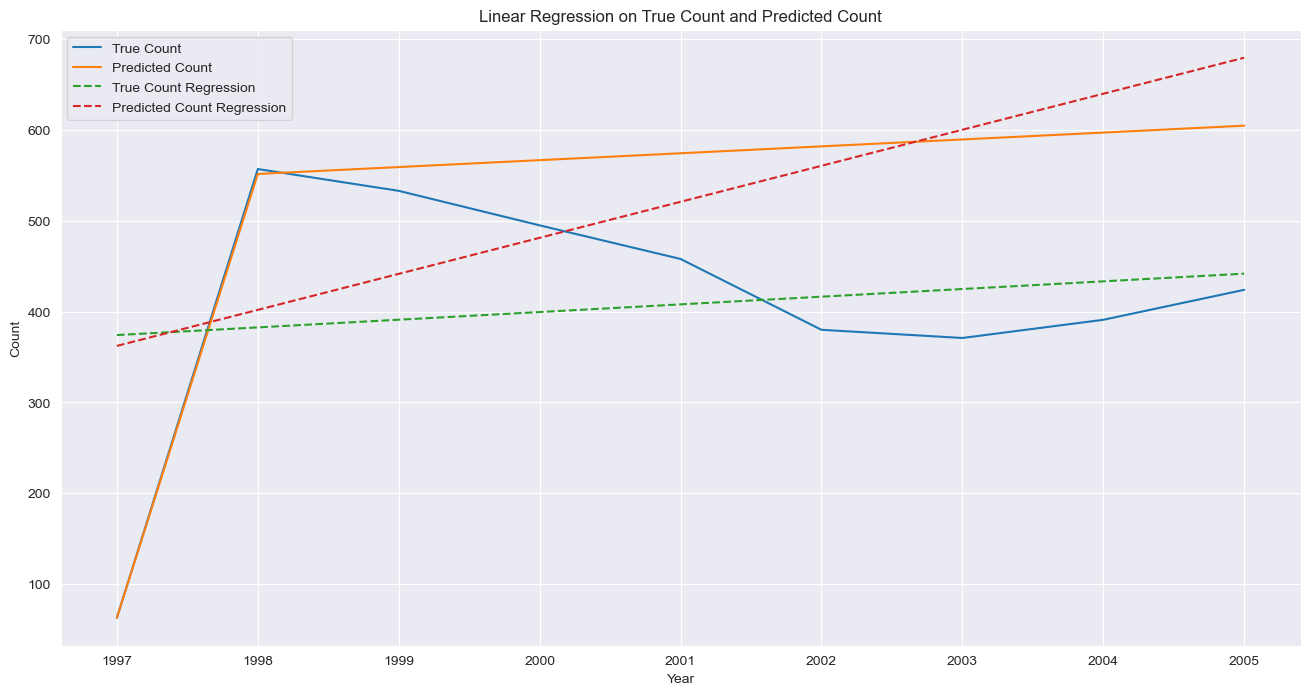

In [24]:
prediction_random = predict_naming_ARIMA(global_names, "CHARLY", 1997, 8)
prediction_random = augment_prediction_with_stop_year(prediction_random, global_names, "CHARLY", 1997)
linear_regression_on_predictions(prediction_random, 1997, 10, True)

In [37]:
#Take 10 random names with 10 random years and perform linear regression on them
random_names = global_names().sample(10)
random_years = np.random.randint(1900, 2020, 10)

print(random_names)
print(random_years)

random_predictions = []
for i in range(10):
    prediction = predict_naming_ARIMA(global_names, random_names.iloc[i]['Name'], random_years[i], 8)
    prediction = augment_prediction_with_stop_year(prediction, global_names, random_names.iloc[i]['Name'], random_years[i])
    prediction['Slope Ratio'] = linear_regression_on_predictions(prediction, random_years[i], 8, False, True)
    prediction['Name'] = random_names.iloc[i]['Name']
    random_predictions.append(prediction)



         Year       Name Sex  Count
72349    1904   RICHMOND   M     10
1600593  2003      KEVAN   M     29
507174   1950    ROSLYNN   F     11
2187768  2019    LETICIA   F     22
571943   1956    FRANCIS   M   8321
843728   1975       HUGH   M    353
2030721  2013    SHAYANA   F     28
1525291  2001    JULIANA   F   2191
381473   1938   MARLIENE   F      6
1830873  2009  CALEDONIA   F     12
[1955 2009 2001 1936 1938 2018 1928 1972 1975 1978]
UK & France & US : Data is clean and conforms to the expected structure !
Slope of True Count: -1.5
Slope of Predicted Count: 0.023061739368309967
Division of slopes (True Count / Predicted Count): -65.04279560375261
UK & France & US : Data is clean and conforms to the expected structure !
Slope of True Count: -4.000000000000001
Slope of Predicted Count: 3.6006505014154686
Division of slopes (True Count / Predicted Count): -1.1109103753412175
UK & France & US : Data is clean and conforms to the expected structure !
Slope of True Count: 1.85000000

ValueError: All arrays must be of the same length

In [38]:
random_predictions

[   Year  True Count  Predicted Count   Lower CI   Upper CI  Slope Ratio  \
 0  1955          38        38.000000        NaN        NaN   -65.042796   
 1  1956          40        38.345926  23.635926  53.055927   -65.042796   
 2  1957          42        38.345926  21.716369  54.975483   -65.042796   
 3  1958          39        38.345926  19.996534  56.695318   -65.042796   
 4  1959          37        38.345926  18.424625  58.267227   -65.042796   
 5  1960          33        38.345926  16.967987  59.723865   -65.042796   
 6  1961          24        38.345926  15.604459  61.087393   -65.042796   
 7  1962          36        38.345926  14.318185  62.373667   -65.042796   
 8  1963          29        38.345926  13.097354  63.594498   -65.042796   
 
        Name  
 0  RICHMOND  
 1  RICHMOND  
 2  RICHMOND  
 3  RICHMOND  
 4  RICHMOND  
 5  RICHMOND  
 6  RICHMOND  
 7  RICHMOND  
 8  RICHMOND  ,
    Year  True Count  Predicted Count   Lower CI    Upper CI  Slope Ratio  \
 0  2009  

In [64]:
# Take 10 random names with 10 random years and perform linear regression on them
random_names = pd.DataFrame({'Name': ['CHARLY', 'JAMES', 'JULIET']})
random_years = np.random.randint(1950, 2020, 3)

print(random_names)
print(random_years)

random_predictions = []
for i in range(3):
    prediction = predict_naming_ARIMA(global_names, random_names.iloc[i]['Name'], random_years[i], 8)
    prediction = augment_prediction_with_stop_year(prediction, global_names, random_names.iloc[i]['Name'], random_years[i])
    slope_ratio = linear_regression_on_predictions(prediction, random_years[i], 8, False, True)
    prediction_summary = pd.DataFrame({
        'Year': [random_years[i]],
        'Name': [random_names.iloc[i]['Name']],
        'Slope Ratio': [slope_ratio]
    })
    random_predictions.append(prediction_summary)

# Combine all the individual prediction summaries into a single DataFrame
final_df = pd.concat(random_predictions, ignore_index=True)
final_df

     Name
0  CHARLY
1   JAMES
2  JULIET
[1973 1978 2003]
UK & France & US : Data is clean and conforms to the expected structure !
Slope of True Count: 5.250000000000002
Slope of Predicted Count: 0.14549570287762942
Division of slopes (True Count / Predicted Count): 36.08353989956367
UK & France & US : Data is clean and conforms to the expected structure !
Slope of True Count: 2024.7666666666655
Slope of Predicted Count: 2709.3451842737654
Division of slopes (True Count / Predicted Count): 0.7473269476400809
UK & France & US : Data is clean and conforms to the expected structure !
Slope of True Count: 114.16666666666669
Slope of Predicted Count: 0.43963720997472805
Division of slopes (True Count / Predicted Count): 259.6838121896675


,Year,Name,Slope Ratio
0,1973,CHARLY,36.083540
1,1978,JAMES,0.747327
2,2003,JULIET,259.683812


UK & France & US : Data is clean and conforms to the expected structure !
Slope of True Count: 49.73333333333333
Slope of Predicted Count: 0.1
Division of slopes (True Count / Predicted Count): 497.33333333333326


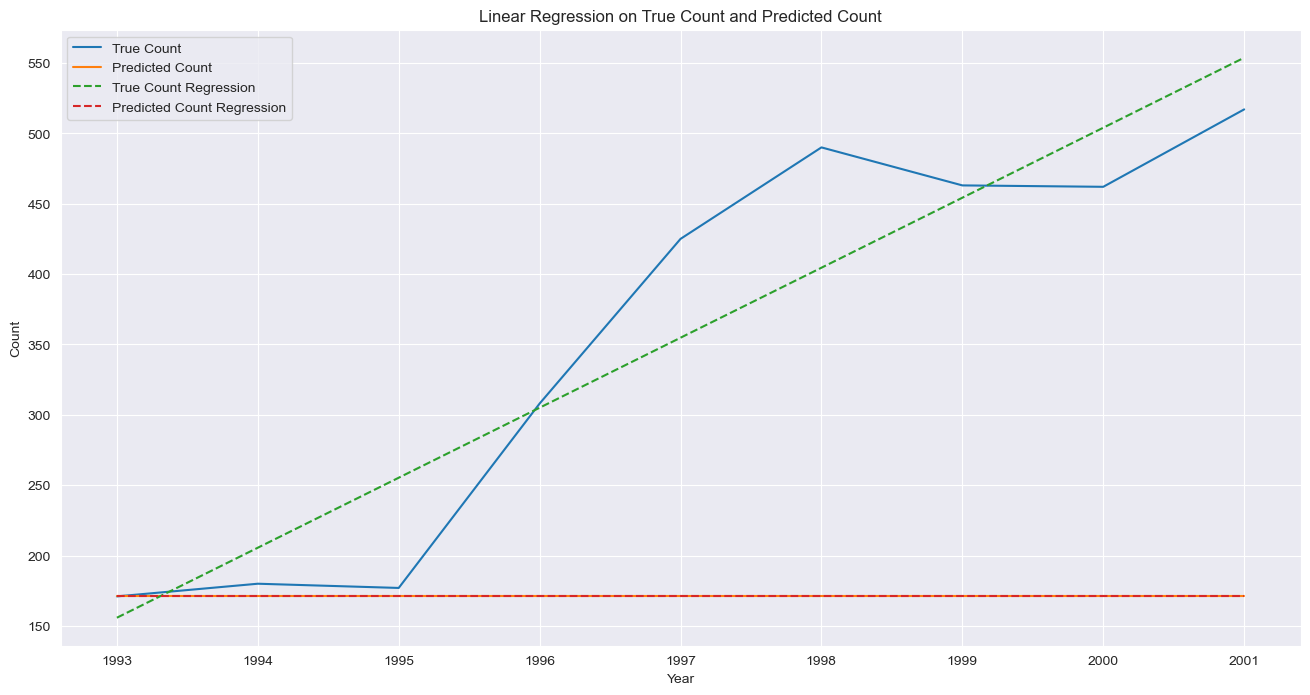

In [63]:
# Show Juliet's prediction in 1953
prediction_JULIET = predict_naming_ARIMA(global_names, "JULIET", 1993, 8)
prediction_JULIET = augment_prediction_with_stop_year(prediction_JULIET, global_names, "JULIET", 1993)
linear_regression_on_predictions(prediction_JULIET, 1993, 8, True)

UK & France & US : Data is clean and conforms to the expected structure !


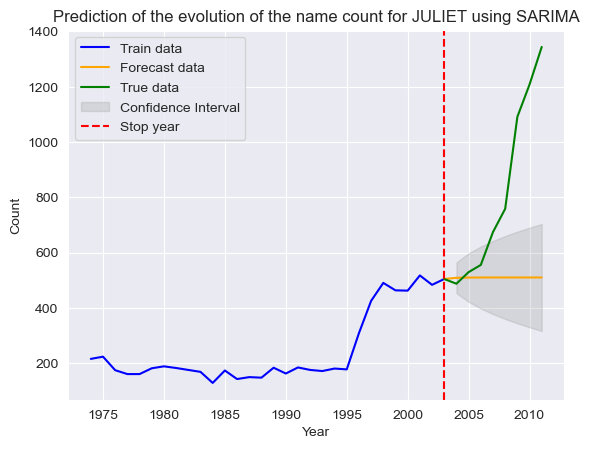

In [66]:
# Trend JULIET in 2003
JULIET_prediction = predict_naming_ARIMA(global_names, "JULIET", 2003, 8, True)